### Import

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, shape
import seaborn as sns
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats 
# import datetime

sys.path.insert(0, '../..')

print("Start: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

from network_v11_13_rebalance import *
from helper_v11_13_rebalance import *

Start: 2025-07-17 22:12:44


### Initialization

#### define agent and gnv boundary

In [2]:
fl_city_boundary = gpd.read_file('Map/fl_city_boundary.shp')
Gainesville_boundary = fl_city_boundary.loc[fl_city_boundary['NAME'] == 'GAINESVILLE'].reset_index(drop=True)
Gainesville_boundary['geometry'] = Gainesville_boundary['geometry'].to_crs('epsg:4326')

grid_centroid_gdf = pd.read_csv('grid_centroid_gdf.csv')
grid_centroid_gdf = grid_centroid_gdf.drop(columns = {'geometry'}, axis = 1)
grid_centroid_gdf['geometry'] = grid_centroid_gdf[['longitude', 'latitude']].values.tolist()
grid_centroid_gdf['geometry'] = grid_centroid_gdf['geometry'].apply(Point)

grid_centroid_gdf = grid_centroid_gdf.loc[grid_centroid_gdf['departure_rate'] > 0].reset_index()

grid_centroid_gdf.head()

,level_0,index,latitude,longitude,departure_rate,arrival_rate,dist_transPOI,num_transPOI,dist_bus_stop,num_bus_stop,rider_test_list,geometry
0,0,29,29.658570,-82.415016,0.022484,0.038544,0.081538,1.0,0.030854,1.0,0,POINT (-82.41501609853275 29.65857013179353)
1,1,30,29.660371,-82.414990,0.002141,0.005353,1.000000,0.0,1.000000,0.0,0,POINT (-82.4149895039865 29.660371378494247)
2,2,47,29.654944,-82.413000,0.001071,0.002141,1.000000,0.0,1.000000,0.0,0,POINT (-82.41300040184892 29.654944475167262)
3,3,48,29.656746,-82.412974,0.004283,0.008565,1.000000,0.0,1.000000,0.0,0,POINT (-82.41297377438231 29.65674571873145)
4,4,49,29.658547,-82.412947,0.078158,0.100642,1.000000,0.0,1.000000,0.0,1,POINT (-82.41294714602218 29.6585469636598)


#### scooter-sharing system configure

In [3]:
service_areas = [] # replace stations
for i in range (len(grid_centroid_gdf)):
    service_areas.append((i, grid_centroid_gdf.geometry.iloc[i], grid_centroid_gdf.departure_rate.iloc[i], grid_centroid_gdf.arrival_rate.iloc[i]))

# Parameter setups for the reward system and elements of the environment.
max_scooter_per_area = 8 # 6
docked_cost_per_deploy = 50/365 # each dock cost 500
scooter_cost_per_deploy = 25/365 # each scooter 250
no_scooter_penalty = 0.5 # 0.5
reward_per_rider = 0.2 # 0.2
nS = len(service_areas)
equity_penalty = 0.0
logistics_car_cost_per_mile = 1.0
logistics_car_capacity = 20

# dist_transPOI_penalty = 0.5
# low_usage_penalty = 1
# dist_bus_stop_penalty = 0.2
# reward_bus_scooter_coverage = 0.2

#### RL model configure

In [4]:
# Parameter setups for the network and training process.
learning_rate = 0.01
n_iters = 25
n_epochs = 500 # 2000
display_step = 50 # 50
batch_size = 256
gamma = 0.9

# The size of the state vector.
nS = len(service_areas) # the number of service areas

In [5]:
## tf.reset_default_graph() only works under tf 1.0

# Set up the state-value estimator and policy estimator
estimator_policy = PolicyEstimator(learning_rate, nS)
estimator_value = StateValueEstimator(learning_rate, nS)

rider_test_list = np.array(grid_centroid_gdf['rider_test_list'])

# Initialize study area
study_area = create_study_area(service_areas, max_scooter_per_area, scooter_cost_per_deploy, docked_cost_per_deploy, \
                   nS, no_scooter_penalty, reward_per_rider, equity_penalty, rider_test_list, logistics_car_cost_per_mile, logistics_car_capacity)

### Training

In [6]:
# Add ops to save and restore all the variables

print("Starting policy gradient...")

# Start training
print("Training in progress...")
avg_rewards, avg_unmet_demand, avg_met_demand, avg_scooter_num, avg_scooter_loc, avg_aWNNR_list, avg_moran_list, avg_gini_list, avg_theil_list, avg_EMD_list, avg_centroid_list, avg_dispersion_list, avg_kl_list, avg_cost, scooter_list = reinforce(study_area, nS, estimator_policy, estimator_value, n_epochs, n_iters, batch_size, display_step)

Starting policy gradient...
Training in progress...


C:\Users\Kaifa Lu\UF Courses\RL\RL_Micromobilityplan\env_v11_13_rebalance.py:558: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_gdf_sorted['value'].iloc[-1] -= ff
C:\Users\Kaifa Lu\UF Courses\RL\RL_Micromobilityplan\env_v11_13_rebalance.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_gdf_sorted['value'].iloc[-1] -= ee
C:\Users\Kaifa Lu\UF Courses\RL\RL_Micromobilityplan\env_v11_13_rebalance.py:968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Epoch 50, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence, rebalancing cost = -74.684, 2.000, 189.000, 189.000, 103.000, 0.491, 0.037, 0.952, 0.246, 2.041, 0.920, -1.757, 0.855, 80.069
Epoch 100, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence, rebalancing cost = -67.874, 5.000, 186.000, 186.000, 103.000, 0.488, 0.037, 0.951, 0.232, 2.028, 0.924, -1.742, 0.857, 71.776
Epoch 150, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersion change, kl divergence, rebalancing cost = -77.541, 6.000, 185.000, 185.000, 103.000, 0.486, 0.038, 0.951, 0.225, 2.016, 0.919, -1.736, 0.862, 80.948
Epoch 200, Average reward, unmet demand, met demand, scooter num, scooter loc, wANNR, moran, gini, theil, EMD, centroid change, dispersio

### Model save

In [7]:
# Save the variables to disk
print("Saving model...")
save_path = os.path.join(os.getcwd(), "policy_grad_model_v12_v11_13_rebalance_grid_base.h5")
estimator_policy.save(save_path)  # Saves both the model architecture and weights

Saving model...


In [8]:
def modified_z_score(arr):

    median = np.median(arr)
    mad = np.median(np.abs(arr - median))  # Median Absolute Deviation

    # Modified Z-score
    modified_z_scores = 0.6745 * (arr - median) / mad
    threshold = 3
    # filtered_arr = arr[np.abs(modified_z_scores) < threshold]
    sel_index = np.abs(modified_z_scores) < threshold
    
    return sel_index # filtered_arr

def IQR(arr):
    
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1

    # Define bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filter out outliers
    filtered_arr = arr[(arr >= lower_bound) & (arr <= upper_bound)]

    return filtered_arr

def standard_z_score(arr):
    # Z-score
    z_scores = np.abs(stats.zscore(arr))
    threshold = 3
    filtered_arr = arr[z_scores < threshold]
    
    return filtered_arr

### Illustration

End: 2025-07-18 00:07:56
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-18 00:07:56


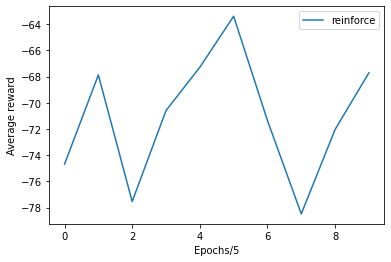

In [9]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
sel_index = modified_z_score(avg_rewards)
print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
plt.plot(np.array(avg_rewards)[sel_index], label="reinforce")
print("Plotting baseline 1...")
plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Average reward")
plt.xlabel("Epochs/5")
#plt.ylim([10, 18])

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-18 00:07:57
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-18 00:07:57


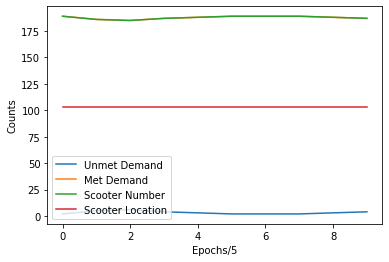

In [10]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
l1, = plt.plot(np.array(avg_unmet_demand)[sel_index], label="Unmet Demand")
l2, = plt.plot(np.array(avg_met_demand)[sel_index], label="Met Demand")
l3, = plt.plot(np.array(avg_scooter_num)[sel_index], label="Scooter Number")
l4, = plt.plot(np.array(avg_scooter_loc)[sel_index], label="Scooter Location")
print("Plotting baseline 1...")
plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Counts")
plt.xlabel("Epochs/5")
#plt.ylim([10, 18])

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-18 00:07:57
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-18 00:07:57


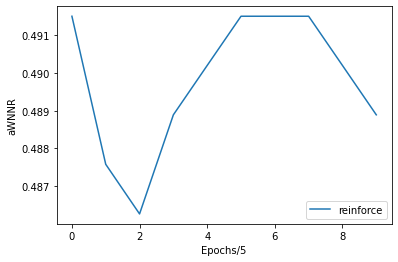

In [11]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
plt.plot(np.array(avg_aWNNR_list)[sel_index], label="reinforce")
print("Plotting baseline 1...")
plt.legend(loc='best',prop={'size': 10})
plt.ylabel("aWNNR")
plt.xlabel("Epochs/5")
#plt.ylim([10, 18])

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-18 00:07:57
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-18 00:07:57


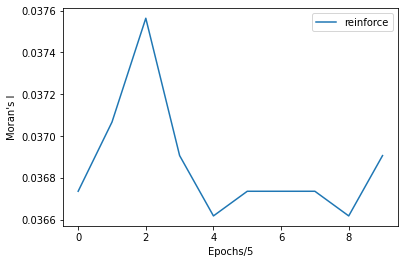

In [12]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
plt.plot(np.array(avg_moran_list)[sel_index], label="reinforce")
print("Plotting baseline 1...")
plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Moran's I")
plt.xlabel("Epochs/5")
#plt.ylim([10, 18])

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-18 00:07:57
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-18 00:07:57


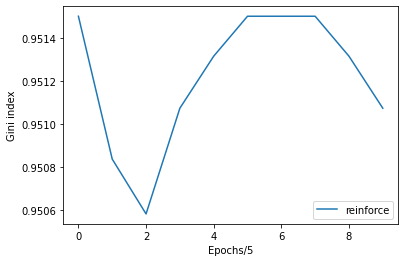

In [13]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
plt.plot(np.array(avg_gini_list)[sel_index], label="reinforce")
print("Plotting baseline 1...")
plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Gini index")
plt.xlabel("Epochs/5")
#plt.ylim([10, 18])

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-18 00:07:57
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-18 00:07:57


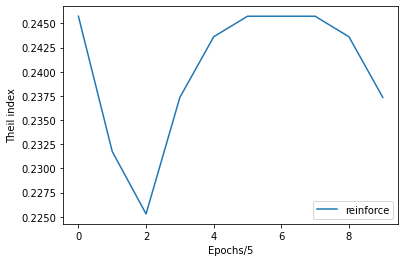

In [14]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
plt.plot(np.array(avg_theil_list)[sel_index], label="reinforce")
print("Plotting baseline 1...")
plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Theil index")
plt.xlabel("Epochs/5")
#plt.ylim([10, 18])

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-18 00:07:57
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-18 00:07:57


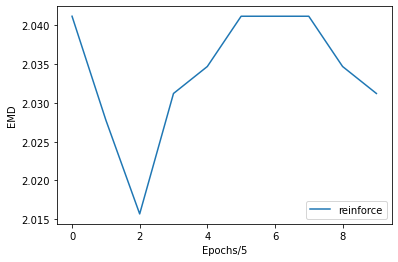

In [15]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
plt.plot(np.array(avg_EMD_list)[sel_index], label="reinforce")
print("Plotting baseline 1...")
plt.legend(loc='best',prop={'size': 10})
plt.ylabel("EMD")
plt.xlabel("Epochs/5")
#plt.ylim([10, 18])

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-18 00:07:57
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-18 00:07:57


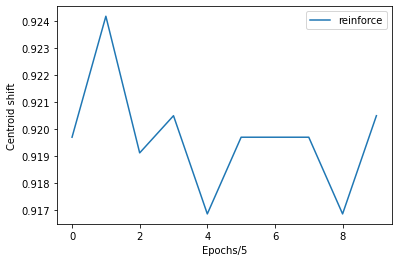

In [16]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
plt.plot(np.array(avg_centroid_list)[sel_index], label="reinforce")
print("Plotting baseline 1...")
plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Centroid shift")
plt.xlabel("Epochs/5")
#plt.ylim([10, 18])

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

End: 2025-07-18 00:07:57
Plotting resulting graph...
Plotting baseline 1...
End: 2025-07-18 00:07:57


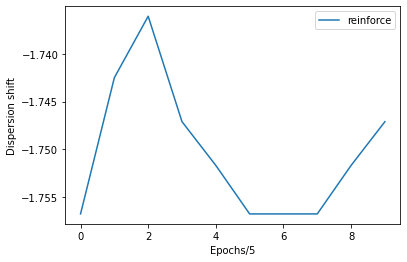

In [17]:
# Plot the graphs of average rewards during testing phases of the policy
# gradient method and the hand-crafted policies

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

print("Plotting resulting graph...")
# plt.figure(figsize = (12, 9))
plt.plot(np.array(avg_dispersion_list)[sel_index], label="reinforce")
print("Plotting baseline 1...")
plt.legend(loc='best',prop={'size': 10})
plt.ylabel("Dispersion shift")
plt.xlabel("Epochs/5")
#plt.ylim([10, 18])

print("End: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [18]:
scooter_num_arr = np.zeros(nS)
for i in range(len(scooter_list)):
    if scooter_list[i] != 0:
        scooter_num_arr[i] = scooter_list[i].scooters_total

grid_centroid_gdf['scooter_deploy_num'] = scooter_num_arr
print(np.sum(scooter_num_arr != 0))
np.sum(scooter_num_arr)

103


187.0

(-82.43244846431782, -82.21231861289532, 29.58878255923895, 29.78745371130791)

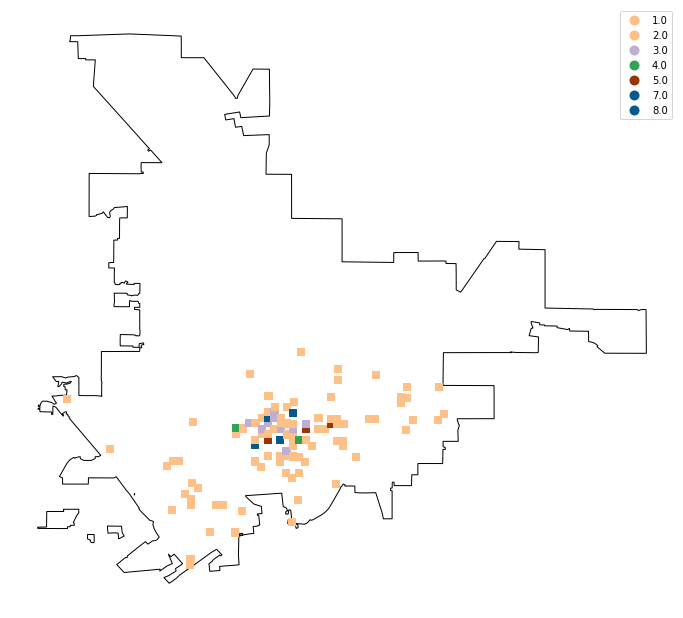

In [19]:
# Plot the divided areas
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'

grid_centroid_gdf_plot = grid_centroid_gdf.loc[grid_centroid_gdf['scooter_deploy_num'] > 0]

# colors = ["#7fc97f", "#beaed4",  "#fdc086", "#ffff99",  "#386cb0"]  # Custom colors
colors = ['#fdc086', '#beaed4', '#31a354', '#993404', '#045a8d']
cmap = mcolors.ListedColormap(colors)

gpd.GeoDataFrame(grid_centroid_gdf_plot).plot(column = 'scooter_deploy_num', marker = 's', markersize = 50, ax=base1, cmap=cmap, legend=True, categorical=True)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')

plt.axis("off")

(-9176338.187890625, -9151833.444921874, 3450799.346875, 3476257.0593749997)

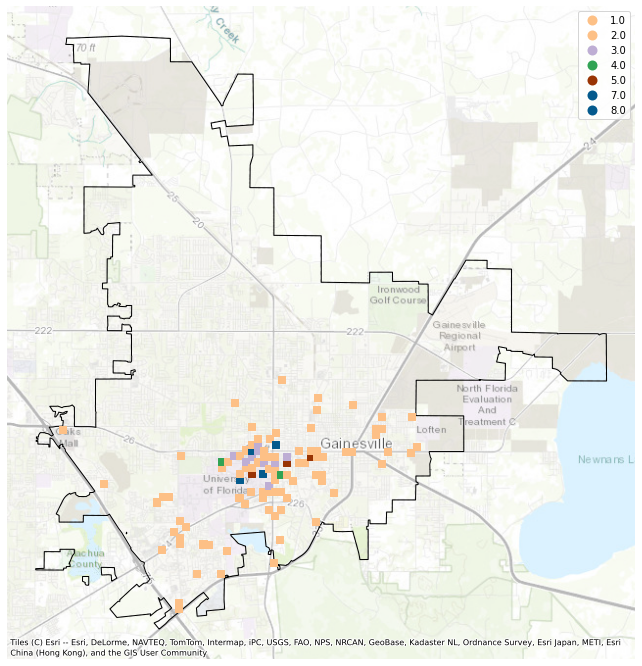

In [20]:
import contextily as ctx

Gainesville_boundary_new = Gainesville_boundary.to_crs(epsg=3857)

grid_centroid_gdf_plot_new = gpd.GeoDataFrame(grid_centroid_gdf_plot)
grid_centroid_gdf_plot_new['geometry'] = grid_centroid_gdf_plot_new['geometry'].set_crs(epsg=4326).to_crs(epsg=3857) # 

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)

base1 = Gainesville_boundary_new.plot(ax=ax, edgecolor='black', facecolor='none')
# colors = ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
# colors = ['#eff3ff', '#bdd7e7', '#6baed6', '#3182bd', '#08519c']
colors = ['#fdc086', '#beaed4', '#31a354', '#993404', '#045a8d']
# colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']
# colors = ['#ffffd4', '#fed98e', '#fe9929', '#d95f0e', '#993404']

cmap = mcolors.ListedColormap(colors)

grid_centroid_gdf_plot_new.plot(column = 'scooter_deploy_num', marker = 's', markersize = 50, ax=base1, cmap=cmap, legend=True, categorical=True)
# plt.tight_layout()
# ctx.add_basemap(ax, source=ctx.providers.NASAGIBS.ModisTerraTrueColorCR, alpha=0.9)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap, alpha=0.7) #ctx.providers.CartoDB.Positron)
# plt.show()
plt.axis("off")

In [ ]:
GNV_scooter_parking_loc = pd.read_csv('Micromobility_Parking_GNV.csv')
GNV_scooter_parking_loc['geometry'] = GNV_scooter_parking_loc[['Longitude', 'Latitude']].values.tolist()
GNV_scooter_parking_loc['geometry'] = GNV_scooter_parking_loc['geometry'].apply(Point)
GNV_scooter_parking_loc_new = gpd.GeoDataFrame(GNV_scooter_parking_loc)

GNV_scooter_parking_loc_new['geometry'] = GNV_scooter_parking_loc_new['geometry'].set_crs(epsg=4326).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off') # remove the axies
divider = make_axes_locatable(ax)

base1 = Gainesville_boundary_new.plot(ax=ax, facecolor = 'none', edgecolor = 'black') # color='#d3d3d3'

GNV_scooter_parking_loc_new.plot(ax=base1,  markersize = 100, marker='^', color = 'white', edgecolor = 'black' )

colors = ['#fdc086', '#beaed4', '#31a354', '#993404', '#045a8d']
cmap = mcolors.ListedColormap(colors)

grid_centroid_gdf_plot_new.plot(column = 'scooter_deploy_num', marker = 's', markersize = 50, ax=base1, cmap=cmap, legend=True, categorical=True)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
# ctx.add_basemap(ax, source=ctx.providers.NASAGIBS.ModisTerraTrueColorCR, alpha=0.9)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap, alpha=0.7) #ctx.providers.CartoDB.Positron)

In [ ]:
GNV_scooter_parking_loc = pd.read_csv('Micromobility_Parking_GNV.csv')
GNV_scooter_parking_loc['geometry'] = GNV_scooter_parking_loc[['Longitude', 'Latitude']].values.tolist()
GNV_scooter_parking_loc['geometry'] = GNV_scooter_parking_loc['geometry'].apply(Point)
GNV_scooter_parking_loc_new = gpd.GeoDataFrame(GNV_scooter_parking_loc)

GNV_scooter_parking_loc_new['geometry'] = GNV_scooter_parking_loc_new['geometry'].set_crs(epsg=4326).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off') # remove the axies
divider = make_axes_locatable(ax)

base1 = Gainesville_boundary_new.plot(ax=ax, facecolor = 'none', edgecolor = 'black') # color='#d3d3d3'

colors = ['#fdc086', '#beaed4', '#31a354', '#993404', '#045a8d']
cmap = mcolors.ListedColormap(colors)

grid_centroid_gdf_plot_new.plot(column = 'scooter_deploy_num', marker = 's', markersize = 50, ax=base1, cmap=cmap, legend=True, categorical=True)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
# ctx.add_basemap(ax, source=ctx.providers.NASAGIBS.ModisTerraTrueColorCR, alpha=0.9)

GNV_scooter_parking_loc_new.plot(ax=base1,  markersize = 100, marker='^', color = 'white', edgecolor = 'black' )

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap, alpha=0.7) #ctx.providers.CartoDB.Positron)

In [ ]:
GNV_scooter_parking_loc = pd.read_csv('Micromobility_Parking_GNV.csv')
GNV_scooter_parking_loc['geometry'] = GNV_scooter_parking_loc[['Longitude', 'Latitude']].values.tolist()
GNV_scooter_parking_loc['geometry'] = GNV_scooter_parking_loc['geometry'].apply(Point)
GNV_scooter_parking_loc_new = gpd.GeoDataFrame(GNV_scooter_parking_loc)

GNV_scooter_parking_loc_new['geometry'] = GNV_scooter_parking_loc_new['geometry'].set_crs(epsg=4326).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off') # remove the axies
divider = make_axes_locatable(ax)

base1 = Gainesville_boundary_new.plot(ax=ax, facecolor = 'none', edgecolor = 'black') # color='#d3d3d3'

GNV_scooter_parking_loc_new.plot(ax=base1,  markersize = 80, marker='^', color = 'white', edgecolor = 'black', legend = True)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap, alpha=0.7) #ctx.providers.CartoDB.Positron)

ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db


(-82.43244846431782, -82.21231861289532, 29.58878255923895, 29.78745371130791)

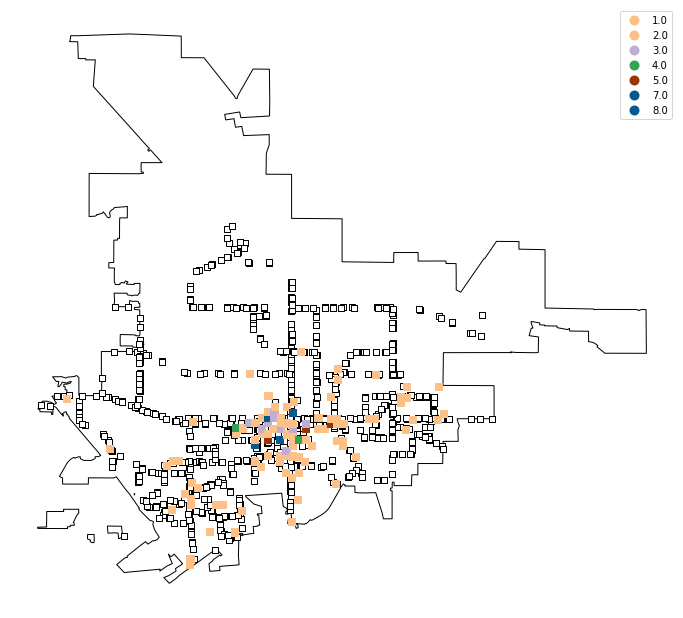

In [21]:
GNV_bus_stop_gdf = gpd.read_file('Map/RTSBusStops_Spring2025.shp')
GNV_bus_stop_gdf = gpd.GeoDataFrame(GNV_bus_stop_gdf)

GNV_bus_stop_gdf_bnd = GNV_bus_stop_gdf.loc[GNV_bus_stop_gdf.geometry.within(Gainesville_boundary.unary_union)]

import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'

GNV_bus_stop_gdf_bnd.plot(ax=base1,  marker='s', color = 'white', edgecolor = 'black' )

grid_centroid_gdf_plot = grid_centroid_gdf.loc[grid_centroid_gdf['scooter_deploy_num'] > 0]

colors = ['#fdc086', '#beaed4', '#31a354', '#993404', '#045a8d']
cmap = mcolors.ListedColormap(colors)

gpd.GeoDataFrame(grid_centroid_gdf_plot).plot(column = 'scooter_deploy_num', marker = 's', markersize = 50, ax=base1, cmap=cmap, legend=True, categorical=True)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')

plt.axis("off")

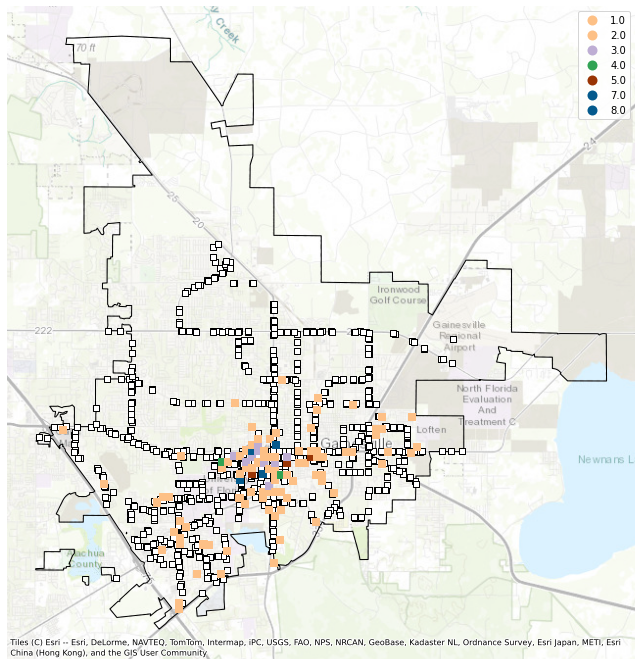

In [22]:
GNV_bus_stop_gdf_bnd_new = gpd.GeoDataFrame(GNV_bus_stop_gdf_bnd)
GNV_bus_stop_gdf_bnd_new['geometry'] = GNV_bus_stop_gdf_bnd_new['geometry'].to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off') # remove the axies
divider = make_axes_locatable(ax)

base1 = Gainesville_boundary_new.plot(ax=ax, facecolor = 'none', edgecolor = 'black') # color='#d3d3d3'

GNV_bus_stop_gdf_bnd_new.plot(ax=base1,  marker='s', color = 'white', edgecolor = 'black' )

colors = ['#fdc086', '#beaed4', '#31a354', '#993404', '#045a8d']
cmap = mcolors.ListedColormap(colors)

grid_centroid_gdf_plot_new.plot(column = 'scooter_deploy_num', marker = 's', markersize = 50, ax=base1, cmap=cmap, legend=True, categorical=True)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
# ctx.add_basemap(ax, source=ctx.providers.NASAGIBS.ModisTerraTrueColorCR, alpha=0.9)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap, alpha=0.7) #ctx.providers.CartoDB.Positron)

ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db


3890
2936


(-82.43244846431782, -82.21231861289532, 29.58878255923895, 29.78745371130791)

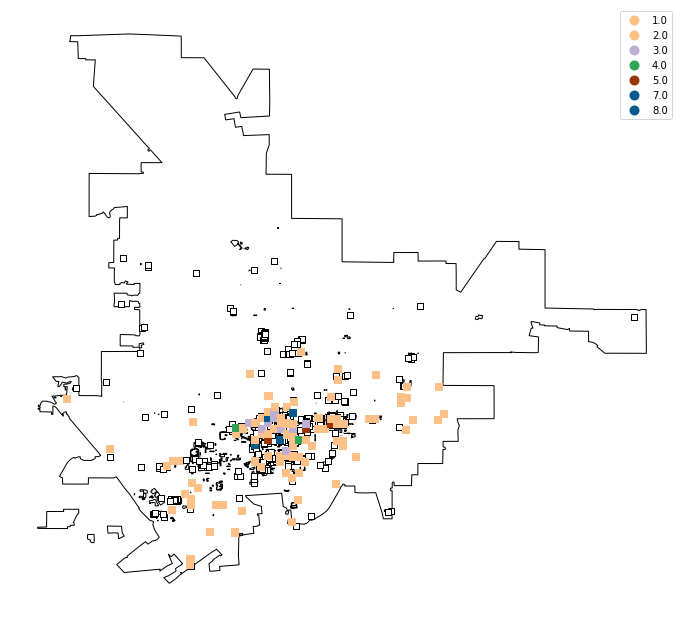

In [23]:
## Transportation POI
alachua_poi = gpd.read_file('Map/alachua_county_poi.geojson')
transportation_poi_list = ['parking_entrance', 'vehicle_inspection', 'parking_space', 'ranger_station',  'boat_rental', 'motorcycle_parking', 'charging_station', 'bicycle_repair_station', 'ferry_terminal', 'bicycle_rental', 'car_rental', 'bicycle_parking', 'parking', 'post_box', 'car_sharing', 'fuel', 'taxi', 'bus_station']
print(len(alachua_poi))
## only keep transportation poi in gnv
gnv_poi = alachua_poi[Gainesville_boundary.geometry.loc[0].contains(alachua_poi.geometry)].reset_index(drop = True)
print(len(gnv_poi))
gnv_trans_poi = gnv_poi[gnv_poi.amenity.isin(transportation_poi_list)].reset_index(drop=True)

import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'

gnv_trans_poi.plot(ax=base1,  marker='s', color = 'white', edgecolor = 'black' )

grid_centroid_gdf_plot = grid_centroid_gdf.loc[grid_centroid_gdf['scooter_deploy_num'] > 0]

colors = ['#fdc086', '#beaed4', '#31a354', '#993404', '#045a8d']
cmap = mcolors.ListedColormap(colors)

gpd.GeoDataFrame(grid_centroid_gdf_plot).plot(column = 'scooter_deploy_num', marker = 's', markersize = 50, ax=base1, cmap=cmap, legend=True, categorical=True)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

(-9176338.187890625, -9151833.444921874, 3450799.346875, 3476257.0593749997)

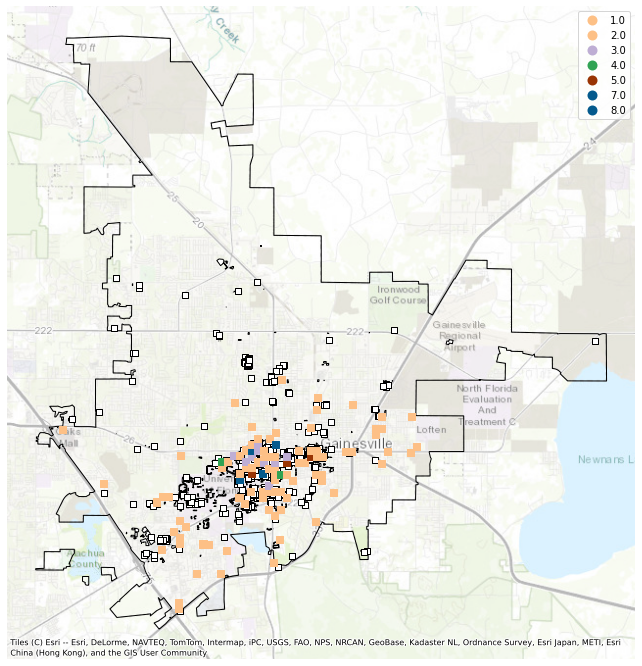

In [24]:
gnv_trans_poi_new = gpd.GeoDataFrame(gnv_trans_poi)
gnv_trans_poi_new['geometry'] = gnv_trans_poi_new['geometry'].to_crs(epsg=3857)

import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary_new.plot(ax=ax, facecolor = 'none', edgecolor = 'black') # color='#d3d3d3'

gnv_trans_poi_new.plot(ax=base1,  marker='s', color = 'white', edgecolor = 'black' )

colors = ['#fdc086', '#beaed4', '#31a354', '#993404', '#045a8d']
cmap = mcolors.ListedColormap(colors)

grid_centroid_gdf_plot_new.plot(column = 'scooter_deploy_num', marker = 's', markersize = 50, ax=base1, cmap=cmap, legend=True, categorical=True)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap, alpha=0.7) #ctx.providers.CartoDB.Positron)
plt.axis("off")

In [25]:
for i in range(len(scooter_list)):
    if scooter_list[i] != 0:
        print(scooter_list[i].scooters_total)

0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
